In [1]:
using JLD, HDF5
using PyPlot

In [2]:
include("src/PlotTools.jl")

PlotTools

In [3]:
include("src/CFTutils.jl")
import CFTutils
CFT = CFTutils

CFTutils

In [4]:
include("src/EDutils.jl")
include("src/LatCFT.jl")
import LatCFT
LCFT = LatCFT

LatCFT

In [5]:
cset = [(0.121569,0.466667,0.705882),(0.682353,0.780392,0.909804),(1.0,0.498039,0.054902),(1.0,0.733333,0.470588),(0.172549,0.627451,0.172549),(0.596078,0.87451,0.541176),(0.839216,0.152941,0.156863),(1.0,0.596078,0.588235),(0.580392,0.403922,0.741176),(0.772549,0.690196,0.835294),(0.54902,0.337255,0.294118),(0.768627,0.611765,0.580392),(0.890196,0.466667,0.760784),(0.968627,0.713725,0.823529),(0.498039,0.498039,0.498039),(0.780392,0.780392,0.780392),(0.737255,0.741176,0.133333),(0.858824,0.858824,0.552941),(0.0901961,0.745098,0.811765),(0.619608,0.854902,0.898039)];

In [7]:
##For TeX rendering of plot text, uncomment this.
#PyPlot.rc("font", family="serif")
#PyPlot.rc("font", size=11)
#PyPlot.rc("text", usetex=true)
#rc("text.latex", preamble="\\usepackage\{lmodern\}")

In [6]:
pricols = cset[[1,3,5]];

# Ising model demo

## Load data
To regenerate the data, run the "ED" script (for the Ising model, a reasonable desktop computer should have enough memory).

In [8]:
modelname = "ising";

In [9]:
datapath = "data/";

In [10]:
ev_data = load("$(datapath)$(modelname)_LCFTdata.jld", "ev");

In [11]:
Hs_data = load("$(datapath)$(modelname)_LCFTdata.jld", "Hs");

In [12]:
norm_facs = LCFT.normalising_factors(ev_data, Hs_data)

Dict{Int64,Float64} with 15 entries:
  16 => 1.28766
  11 => 0.896491
  7  => 0.591009
  9  => 0.742227
  10 => 0.819101
  17 => 1.36638
  8  => 0.66608
  6  => 0.517638
  4  => 0.382683
  5  => 0.447214
  13 => 1.05232
  14 => 1.1306
  15 => 1.20906
  12 => 0.974261
  18 => 1.44519

## Action of H2 on $I$
No corrections.

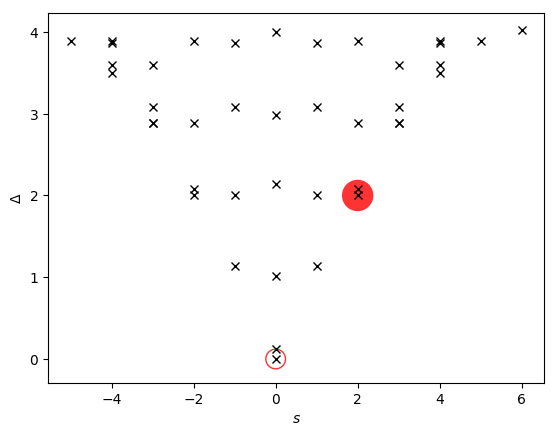

In [13]:
let N = 12, ev_num = 1
    H1,H2 = Hs_data[N][1:2]
    ols = LCFT.plot_spec(ev_num, N, ev_data[N], H2, norm_fac=norm_facs[N], mom_res=1)
    ols[abs(ols) .> 1e-13]
end;

## Central charge from the energy spectrum

a = 0.4999572038404486
ys = [-1.30656,-1.29443,-1.2879,-1.28399,-1.28146,-1.27973,-1.27849,-1.27758,-1.27688,-1.27634,-1.27591,-1.27557,-1.27529,-1.27505,-1.27486]
(a,b) = (-1.2732366367725447,-0.5249565229509185)
(a,b) = 

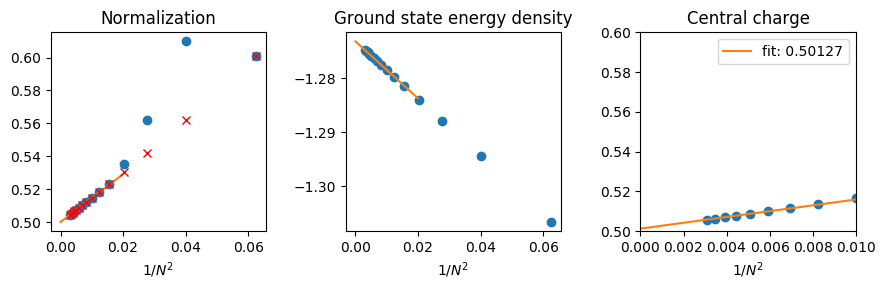

(0.5012695040060136,1.461462529046361)
Ns = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
cs = [0.612165,0.617052,0.566529,0.53876,0.525687,0.520253,0.516428,0.51364,0.511551,0.509953,0.50871,0.50773,0.50695,0.506326,0.505823]


In [14]:
cs_en, nf_en = let Ns = sort(collect(keys(norm_facs))), fitlastn_zeta = 4, fitlastn_c = 5, fitlastn_e0 = 5
    figure(figsize=(9,3))
    subplot(131)
    
    #Compute normalization factors using lowest-energy p=±2 states
    E0s = [ev_data[n][1][1] for n in Ns]
    inds = Dict((n, findfirst(p->abs(p-2.0) < 1e-10, angle(ev_data[n][2])/2π * n)) for n in Ns)
    Ep2s = [ev_data[n][1][inds[n]] for n in Ns]
    nfs_mod = 2./(Ep2s - E0s)
    norm_facs_en = Dict{Int, Float64}((Ns[j], nfs_mod[j]) for j in 1:length(Ns))
    nfs = 2π * nfs_mod ./ Ns
    
    #Normalization factors from T states
    nfsT = [2π * norm_facs[N] / N for N in Ns]
    
    xs = 1./Ns.^2
    title("Normalization")
    plot(xs, nfs, "o")
    xlabel(L"1/N^2")
    #xlim((0.0,0.021))
    #ylim((0.498,0.532))
    
    #Extrapolate a normalization factor (not used in the following)
    a, b = linreg(xs[end-fitlastn_zeta:end], nfs[end-fitlastn_zeta:end])
    fitxs = [0.0, 0.02]
    plot(fitxs, a + b * fitxs, "-")
    @show a
    plot(xs, nfsT, "rx")
    
    #Extrapolate the ground-state energy density e0
    subplot(132)
    title("Ground state energy density")
    xs = 1./Ns.^2
    e0s = [ev_data[N][1][1] for N in Ns]
    ys = (e0s ./ Ns)
    @show ys
    plot(xs, ys, "o")
    xlabel(L"1/N^2")
    a, b = linreg(xs[end-fitlastn_e0:end], ys[end-fitlastn_e0:end])
    plot(fitxs, a + b * fitxs, "-")
    @show a, b
    e0 = a
    
    #Subracting N*e0, extrapolate an estimate for c!
    subplot(133)
    title("Central charge")
    cs = -6/π * (e0s./Ns - e0) .* Ns.^2 .* nfs
    plot(xs, cs, "o")
    xlabel(L"1/N^2")
    a, b = linreg(xs[end-fitlastn_c:end], cs[end-fitlastn_c:end])
    fitxs = [0.0, 0.02]
    astr = @sprintf "%.5f" real(a)
    plot(fitxs, a + b * fitxs, "-", label="fit: $astr")
    @show a, b
    legend()
    xlim(0.00,0.01)
    ylim(0.5,0.6)

    tight_layout()

    @show Ns
    @show cs
    cs, norm_facs_en
end;

## Central charge, with Potts data

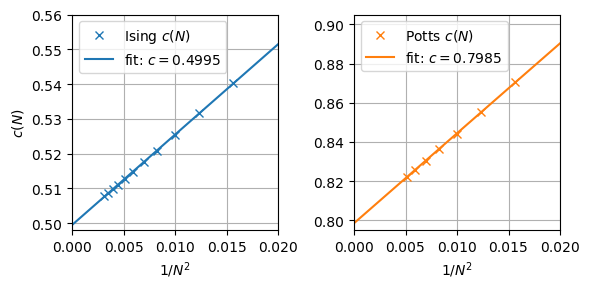

[ns cs] = Complex{Float64}[4.0+0.0im 0.60642+0.0im; 5.0+0.0im 0.611146+0.0im; 6.0+0.0im 0.574374+0.0im; 7.0+0.0im 0.553452+0.0im; 8.0+0.0im 0.540349+0.0im; 9.0+0.0im 0.531575+0.0im; 10.0+0.0im 0.5254+0.0im; 11.0+0.0im 0.520886+0.0im; 12.0+0.0im 0.517483+0.0im; 13.0+0.0im 0.514852+0.0im; 14.0+0.0im 0.512776+0.0im; 15.0+0.0im 0.511108+0.0im; 16.0+0.0im 0.509748+0.0im; 17.0+0.0im 0.508623+0.0im; 18.0+0.0im 0.507684+0.0im]
ns[fitn] = [8,9,10,11,12,13,14,15,16,17,18]
ns_potts[fitn_potts] = [8,9,10,11,12,13,14]


In [22]:
let ns = sort(collect(keys(Hs_data))), Npow = 2, Npow_potts = 2
    cs = [LCFT.estimate_c(Hs_data[n]) for n in ns]
    @show [ns cs]
    cs_potts = [1.14429,0.996499,0.930711,0.893591,0.870465,0.855034,0.844204,0.836302,0.830353,0.825762,0.822142]
    ns_potts = collect(4:14)
    
    fitn = length(cs)-10:length(cs)
    a1, b1 = linreg(1 ./ ns[fitn].^Npow, cs[fitn])
    @show ns[fitn]
    
    #a2, b2 = linreg(1 ./ ns[fitn].^Npow, cs_en[fitn])
    
    fitn_potts = length(cs_potts)-6:length(cs_potts)
    a3, b3 = linreg(1 ./ ns_potts[fitn_potts].^Npow_potts, cs_potts[fitn_potts])
    @show ns_potts[fitn_potts]
    
    figure(figsize=(6,3))
    subplot(121)
    xs = 1 ./ ns.^Npow
    xs_fit = linspace(0, maximum(xs))
    plot(xs, cs, "x", label="Ising \$c(N)\$", color=cset[1])
    a1str = @sprintf "%.4f" real(a1)
    plot(xs_fit, a1 + b1 * xs_fit, "-", label="fit: \$c=$(a1str)\$", color=cset[1])
    #plot([0.0, xs[1]], [0.5,0.5], "k--")
    xlim((0.0, 0.02))
    ylim((0.498, 0.56))
    xlabel("\$1/N^{$(Npow)}\$")
    ylabel(L"c(N)")
    legend(loc=2)
    grid()
    
    #annotate("\$c=$(a1str)\$", xy=(0.0003,0.496))
    
    subplot(122)
    xs_potts = 1 ./ ns_potts.^Npow_potts
    xs_fit = linspace(0, maximum(xs_potts))
    plot(xs_potts, cs_potts, "x", label="Potts \$c(N)\$", color=cset[3])
    a3str = @sprintf "%.4f" real(a3)
    plot(xs_fit, a3 + b3 * xs_fit, "-", label="fit: \$c=$(a3str)\$", color=cset[3])
    #plot([0.0, xs_potts[1]], [0.8,0.8], "k--")
    xlim((0.0, 0.02))
    ylim((0.795, 0.905))
    xlabel("\$1/N^{$(Npow_potts)}\$")
    #ylabel(L"c(N)")
    legend(loc=2)
    grid()
    #annotate("\$c=$(a3str)\$", xy=(0.0003,0.792))
    
    tight_layout()
    #PlotTools.savepdf_cropped("plots/ising_potts_c.pdf")
    #savefig("plots/ising_potts_c.png", dpi=300)
    
    #a1, a2, a3
end

## Examples of the action of $H_n$

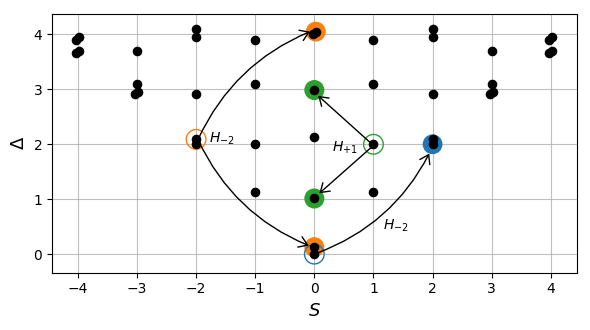

In [24]:
let N = 14, blob_min = 0.01
    figure(figsize=(6,3.4))
    grid(alpha=0.8)
    en, Tev = ev_data[N]
    en = norm_facs[N] * (en - en[1])
    moms = LCFT.moms_Tev(Tev, N, 1)
    
    xs_p, ys_p = PlotTools.pointexclusion1D(moms, en, 0.08, 0.05, 2)
    scatter(xs_p, ys_p, c="k", marker="o", s=35, zorder=10)
    
    H1, H2 = Hs_data[N][1:2]
    
    evnum = 11
    ols = vec(H2[:,evnum])
    scatter(xs_p[evnum], ys_p[evnum], marker="o", s=200, zorder=5, edgecolors=pricols[2], facecolors="none")
    scatter(xs_p, ys_p, c=pricols[2], marker="o", s=15*log10(10^12*abs(ols)), zorder=5)
    
    evnum = 1
    ols = vec(H2[:,evnum])
    scatter(xs_p[evnum], ys_p[evnum], marker="o", s=200, zorder=5, edgecolors=pricols[1], facecolors="none")
    scatter(xs_p, ys_p, c=pricols[1], marker="o", s=15*log10(10^12*abs(ols)), zorder=5)
    
    evnum = 7
    ols = vec(H1'[:,evnum])
    scatter(xs_p[evnum], ys_p[evnum], marker="o", s=200, zorder=5, edgecolors=pricols[3], facecolors="none")
    scatter(xs_p, ys_p, c=pricols[3], marker="o", s=15*log10(10^12*abs(ols)), zorder=5)
    
    as = "->,head_length=0.6,head_width=0.4"
    
    annotate("", xy=(2.0 - 0.035, 1.66*norm_facs[N]), xytext=(0.0, 0.0), ha="center", va="center", zorder=20,
        arrowprops=Dict("arrowstyle"=>as, "connectionstyle"=>"arc3,rad=+0.2"))
    annotate(L"{H}_{-2}", xy=(0.62 * N/(2π), 0.45*norm_facs[N]), ha="center", va="center", zorder=20)
    
    annotate("", xy=(-0.03, 3.60*norm_facs[N]), xytext=(-2.0 + 0.02, 1.82*norm_facs[N]), ha="center", va="center", zorder=20,
        arrowprops=Dict("arrowstyle"=>as, "connectionstyle"=>"arc3,rad=-0.2"))
    annotate("", xy=(-0.05, 0.12*norm_facs[N]), xytext=(-2.0 + 0.02, 1.87*norm_facs[N]), ha="center", va="center", zorder=20,
        arrowprops=Dict("arrowstyle"=>as, "connectionstyle"=>"arc3,rad=+0.2"))
    annotate(L"{H}_{-2}", xy=(-0.7 * N/(2π), 1.85*norm_facs[N]), ha="center", va="center", zorder=20)
    
    annotate("", xy=(0.05, 0.95*norm_facs[N]), xytext=(1.0, 1.75*norm_facs[N]), ha="center", va="center", zorder=20,
        arrowprops=Dict("arrowstyle"=>as, "connectionstyle"=>"arc3,rad=+0.0"))
    annotate("", xy=(0.03, 2.58*norm_facs[N]), xytext=(1.0, 1.75*norm_facs[N]), ha="center", va="center", zorder=20,
        arrowprops=Dict("arrowstyle"=>as, "connectionstyle"=>"arc3,rad=+0.0"))
    annotate(L"{H}_{+1}", xy=(0.23 * N/(2π), 1.72*norm_facs[N]), ha="center", va="center", zorder=20)
    
    xlabel(L"S", fontsize=13)
    ylabel(L"\Delta", fontsize=13)
    #ylim((-0.2,4.4))
    #xticks(collect(-4:4))
    #yticks(collect(0:4))
    legend()
    tight_layout()
    #PlotTools.savepdf_cropped("plots/$(modelname)_Haction_v2_N$(N).pdf")
    #savefig("plots/$(modelname)_Haction_v2_N$(N).png", dpi=300)
end

## Identify eigenstates that are quasiprimary
(some quasiprimary states are not eigenstates, but linear combinations of them)

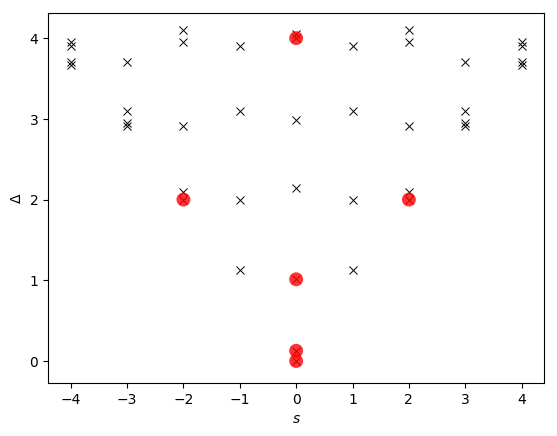

([1,2,3,6,8,38],[0.0,6.264e-16,2.37298e-15,0.179021,0.179021,1.3977e-12,0.503164,7.13289e-13,0.503164,0.746826  …  1.1026,0.503164,1.21628,1.21628,1.21628,1.21628,3.58829e-13,1.05617,0.253174,0.253174])

In [17]:
let N = 14, eps = 1e-10
    LCFT.plot_qps(ev_data[N], Hs_data[N], N, eps, norm_fac=norm_facs[N])
    #savefig("quasiprimaries_e$(eps)_N$(N)_$(modelname).pdf")
end

## Identify eigenstates that are primary

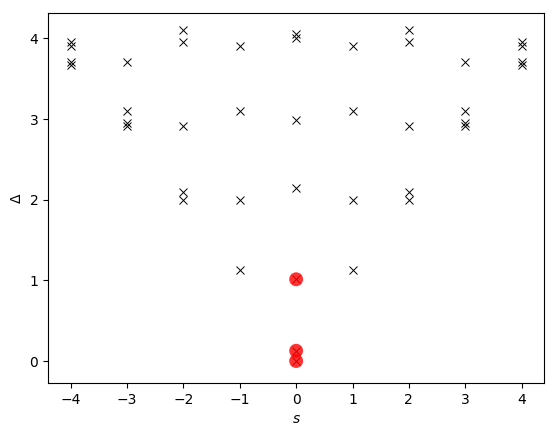

([1,2,3],[0.0,9.1234e-16,3.34654e-15,0.179021,0.179021,0.253174,0.503164,0.253174,0.503164,1.10262  …  1.84943,1.24999,1.21628,1.21628,2.19737,2.19737,0.358042,1.55934,0.608964,0.608964])

In [18]:
let N = 14, eps = 1e-10
    LCFT.plot_ps(ev_data[N], Hs_data[N], N, eps, norm_fac=norm_facs[N], mom_res=1)
    #savefig("primaries_e$(eps)_N$(N)_$(modelname).pdf")
end

## Plot Ising CFT spectrum

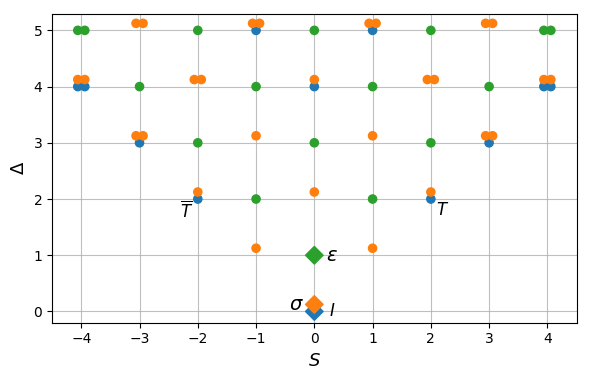

In [25]:
let lblfs = 12
    figure(figsize=(6,3.9))
    grid(alpha=0.8)
    ops = [CFT.ising_cft_eye, CFT.ising_cft_sigma, CFT.ising_cft_epsilon]
    CFT.plot_sops_v3(ops, pricols, 6.5, sz=35, szp=80)
    annotate(L"T", xy=(2.2, 1.8), fontsize=lblfs, va="center", ha="center")
    annotate(L"\overline{T}", xy=(-2.2, 1.8), fontsize=lblfs, va="center", ha="center")
    annotate(L"I", xy=(0.3,0.0), fontsize=lblfs, va="center", ha="center")
    annotate(L"\sigma", xy=(-0.3,1/8), fontsize=14, va="center", ha="center")
    annotate(L"\varepsilon", xy=(0.3,1.0), fontsize=14, va="center", ha="center")
    legend()
    ylim((-0.2, 5.3))
    xlim((-4.5,+4.5))
    xlabel(L"S", fontsize=13)
    ylabel(L"\Delta", fontsize=13)
    xticks(collect(-4:4))
    yticks(collect(0:5))
    tight_layout()
end

## Plot Virasoro towers

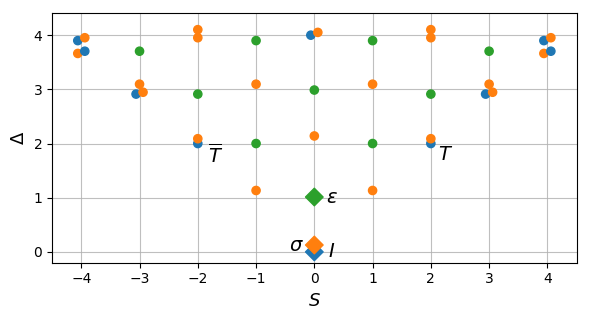

In [26]:
let N = 14, blob_min = 0.01
    figure(figsize=(6,3.3))
    grid(alpha=0.8)
    LCFT.plot_H1H2_towers(ev_data[N], Hs_data[N], norm_facs[N], N,
                      Int[1,2,3], cs=pricols, 
                      pex_yrange=0.06, pex_xspace=0.12, pex_rounddigits=2, sz=35, szp=80)
    annotate(L"T", xy=(2.25, 1.8), fontsize=14, va="center", ha="center")
    annotate(L"\overline{T}", xy=(-1.7, 1.8), fontsize=14, va="center", ha="center")
    annotate(L"I", xy=(0.3,0.0), fontsize=14, va="center", ha="center")
    annotate(L"\sigma", xy=(-0.3,1/8), fontsize=14, va="center", ha="center")
    annotate(L"\varepsilon", xy=(0.3,1.0), fontsize=14, va="center", ha="center")
    xlabel(L"S", fontsize=13)
    ylabel(L"\Delta", fontsize=13)
    ylim((-0.2,4.4))
    xticks(collect(-4:4))
    xlim(-4.5,+4.5)
    #yticks(collect(0:4))
    legend()
    tight_layout()
    #PlotTools.savepdf_cropped("plots/$(modelname)_H1H2_towers_N$(N).pdf")
end

## Plot states with components that are globally descended from selected quasiprimary states

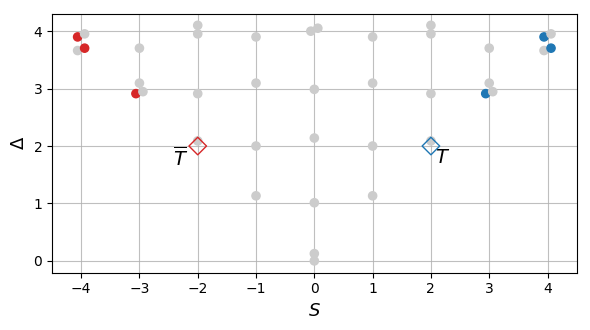

In [21]:
let N = 14, blob_min = 0.01
    figure(figsize=(6,3.4))
    grid(alpha=0.8)
    LCFT.plot_H1_towers(ev_data[N], Hs_data[N], norm_facs[N], N,
                      [8,6], cs=[pricols[1],cset[7]], cdef=(0.8,0.8,0.8),
                      pex_yrange=0.08, pex_xspace=0.12, pex_rounddigits=2, sz=35, szp=80)
    annotate(L"T", xy=(2.2, 1.8), fontsize=14, va="center", ha="center")
    annotate(L"\overline{T}", xy=(-2.3, 1.8), fontsize=14, va="center", ha="center")
    #annotate("\$\\mathbb{I}\$", xy=(0.3,0.0), fontsize=14, va="center", ha="center")
    #annotate(L"\sigma", xy=(-0.3,1/8), fontsize=14, va="center", ha="center")
    #annotate(L"\varepsilon", xy=(0.3,1.0), fontsize=14, va="center", ha="center")
    xlabel(L"S", fontsize=13)
    #ylabel(L"E - E_0")
    ylabel(L"\Delta", fontsize=13)
    #ylim((-0.2,4.4))
    xticks(collect(-4:4))
    #yticks(collect(0:4))
    legend()
    tight_layout()
    #PlotTools.savepdf_cropped("plots/$(modelname)_global_towers_N$(N).pdf")
    #savefig("plots/$(modelname)_global_towers_N$(N).png", dpi=300)
end